In [1]:
from typing import List, Tuple
from helper.helper_functions import load_dataset, save_model, get_features_and_target, encode_nominal_features
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, kstest, pointbiserialr, kendalltau
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression, mutual_info_regression, SelectPercentile, chi2

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = load_dataset('../data/assignment2_income_cleaned.xlsx')

In [3]:
data['ability to speak english'].value_counts()

ability to speak english
0    8597
1     229
2      96
3      64
4      14
Name: count, dtype: int64

In [4]:
income_counts = data.groupby(['income', 'ability to speak english']).size().unstack(fill_value=0)
income_counts

ability to speak english,0,1,2,3,4
income,,,,,
high,2968,78,19,12,2
low,5629,151,77,52,12


In [57]:
# Splitting the data into features (X) and target (y)
X, y = get_features_and_target(data, target_column='income')

columns_to_use = ['age', 'workclass', 'education', 'marital status', 'occupation', 'workinghours', 'sex', 'ability to speak english', 'gave birth this year']

- **Categorical features**:
    - **nominal features**:
        'workclass', 'marital status', 'occupation', 'sex', and 'gave birth this year'
    - **ordinal features**:
        'education', 'ability to speak English'
- **Continuous features**:
    'age', 'workinghours'

### a
Point-biserial correlation is a special case of Pearson correlation coefficient used when one variable is continuous and the other is dichotomous (binary).

https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
https://resources.nu.edu/statsresources/Pointbiserial

Below we check if the continuous features are normally distributed using Shapiro-Wilk and Kolmogorov-Smirnov tests.

In [58]:
continuous_features = ['age', 'workinghours']

for feature in continuous_features:
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p_value = shapiro(data[feature])
    print(f"Shapiro-Wilk Test ({feature}) - Statistic: {shapiro_stat}, P-value: {shapiro_p_value:.10f}")

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = kstest(data[feature], 'norm')
    print(f"Kolmogorov-Smirnov Test ({feature}) - Statistic: {ks_stat}, P-value: {ks_p_value:.10f}")

Shapiro-Wilk Test (age) - Statistic: 0.974037822220245, P-value: 0.0000000000
Kolmogorov-Smirnov Test (age) - Statistic: 1.0, P-value: 0.0000000000
Shapiro-Wilk Test (workinghours) - Statistic: 0.8889242919715895, P-value: 0.0000000000
Kolmogorov-Smirnov Test (workinghours) - Statistic: 0.9946501019683699, P-value: 0.0000000000


In [59]:
binary_class_feature = 'income'
data_ = data.copy()
data_[binary_class_feature] = data_['income'].map({'low': 0, 'high': 1})

for feature in continuous_features:
    point_biserial_corr, p_value = pointbiserialr(data_[feature], data_[binary_class_feature])
    print(f"Point-Biserial Correlation Coefficient for '{feature}': {point_biserial_corr:.3f}, P-value: {p_value:.6f}")

Point-Biserial Correlation Coefficient for 'age': 0.280, P-value: 0.000000
Point-Biserial Correlation Coefficient for 'workinghours': 0.295, P-value: 0.000000


### Feature Encoding

In [60]:
# List of nominal features
nominal_features_lc = ['workclass', 'sex', 'marital status', 'gave birth this year', 'occupation'] # low cardinality features
nominal_features_hc = [] # high cardinality features

# https://towardsdatascience.com/encoding-categorical-variables-a-deep-dive-into-target-encoding-2862217c2753#:~:text=Target%20encoding%20works%20by%20converting,average%20value%20for%20that%20category.
# https://medium.com/@denizgunay/feature-encoding-f099a6c1abe8

X_encoded = encode_nominal_features(X, nominal_features_lc, nominal_features_hc)
y_encoded = y.map({'low': 0, 'high': 1})

In [61]:
X_encoded

,age,education,workinghours,ability to speak english,workclass_governmental,workclass_no paid work,workclass_private,workclass_self employed,sex_Female,sex_Male,...,occupation_Management/Business,occupation_Military Services,occupation_Office/Administrative Support,occupation_Production/Assembly,occupation_Protective Services,occupation_Repair/Maintenance,occupation_Sales,"occupation_Science, Engineering, Technology",occupation_Service/Hospitality,occupation_Transport
0,52,16,50,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,60,20,30,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,64,21,40,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,64,17,40,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,31,15,40,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,28,16,40,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8996,61,24,40,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8997,34,23,50,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8998,60,19,40,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


### Feature Selection: Filter Methods

#### Numerical Input Features

In [62]:
# Calculate Kendall's tau correlation coefficient for each continuous feature
# Pearson's and Spearman's correlation methods won't work here because the target variable is a (dichotomous) categorical variable. Kendall's tau is suitable.
print("\nKendall's Tau Correlation Coefficients:")
for feature in continuous_features:
    kendall_tau_corr, kendall_tau_p_value = kendalltau(data_[feature], data_[binary_class_feature])
    print(f"   {feature}: {kendall_tau_corr:.3f} (p-value: {kendall_tau_p_value:.3f})")


Kendall's Tau Correlation Coefficients:
   age: 0.234 (p-value: 0.000)
   workinghours: 0.290 (p-value: 0.000)


<Axes: >

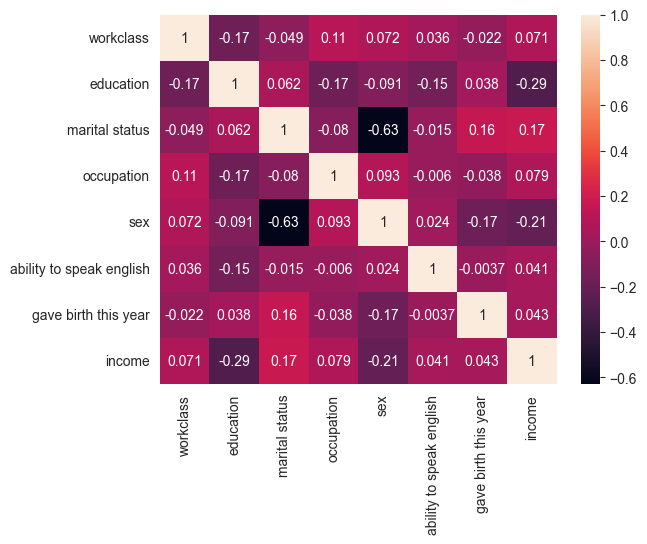

In [63]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
data_encoded = data.drop(columns=continuous_features)
# Encode all categorical features
for col in data_encoded.columns:
    data_encoded[col] = label_encoder.fit_transform(data_encoded[col])
# calculate correlation between all categorical features
sns.heatmap(data_encoded.corr(), annot=True)

#### Categorical Input Features

In [64]:
# https://stackoverflow.com/questions/49847493/using-chi2-test-for-feature-selection-with-continuous-features-scikit-learn
# https://www.hackersrealm.net/post/feature-selection-using-chi-square
# https://resources.nu.edu/statsresources/goodnessoffit
# The SelectPercentile function using chi2 fitted on the encoded dataset gives the same results (meaning internally it's the same process).

X_encoded_cat = X_encoded.drop(columns=continuous_features)
# Calculate chi-squared statistics and p-values between each categorical feature and the target class (**in pairs**)
chi2_stat, p_values = chi2(X_encoded_cat, y)
# Calculate mutual information between each feature and the target class
mutual_info = mutual_info_classif(X_encoded_cat, y)

feature_importance_df = pd.DataFrame({'Feature': X_encoded_cat.columns, 'Chi-squared statistic': chi2_stat, 'P-value': [round(p, 6) for p in p_values], 'Mutual_Info_Importance': mutual_info})
feature_importance_df = feature_importance_df.sort_values(by='Chi-squared statistic', ascending=False)

In [65]:
feature_importance_df

,Feature,Chi-squared statistic,P-value,Mutual_Info_Importance
9,marital status_Husband,673.531893,0.000000,0.060949
10,marital status_Never married,556.620501,0.000000,0.044431
0,education,424.146521,0.000000,0.068971
24,occupation_Management/Business,388.289723,0.000000,0.025729
32,occupation_Service/Hospitality,358.692255,0.000000,0.035741
31,"occupation_Science, Engineering, Technology",290.938216,0.000000,0.018010
6,sex_Female,253.022927,0.000000,0.021557
7,sex_Male,126.511463,0.000000,0.024082
26,occupation_Office/Administrative Support,82.652127,0.000000,0.012165
13,marital status_Wife,67.470942,0.000000,0.002240


For now, there is not much more we can do here. A part of feature selection is concerned with 'selection methods', but we need a model (to evaluate the performance of the selected features). These include: Forward Addition, Backward Elimination (, Recursive Feature Elimination, etc.), Feature Regularization, SHAP, Boruta, etc. In the model files, we might use some of these methods.

### Conclusion

Columns to use (possibly in order of importance): 'age', 'workinghours', 'education', 'marital status' (encoded), 'occupation' (encoded), 'workclass' (encoded)
Columns to exclude: 'sex' (maybe), 'ability to speak english', 'gave birth this year'

### Is the dataset fairly balanced?

In [66]:
# calculate prior for the target class
prior_income = data['income'].value_counts(normalize=True)

In [67]:
prior_income

income
low     0.657889
high    0.342111
Name: proportion, dtype: float64

In [68]:
# calculate prior for the sex feature(s)
prior_sex = data['sex'].value_counts(normalize=True)

In [69]:
prior_sex

sex
Male      0.666667
Female    0.333333
Name: proportion, dtype: float64

In [70]:
high_income_gave_birth = data[(data['gave birth this year'] == 'Yes') & (data['income'] == 'high')].shape[0]
low_income_gave_birth = data[(data['gave birth this year'] == 'Yes') & (data['income'] == 'low')].shape[0]

high_income_no_birth = data[(data['gave birth this year'] == 'No') & (data['income'] == 'high')].shape[0]
low_income_no_birth = data[(data['gave birth this year'] == 'No') & (data['income'] == 'low')].shape[0]

print(f"Number of people with high income who gave birth this year: {high_income_gave_birth}")
print(f"Number of people with low income who gave birth this year: {low_income_gave_birth}")

print(f"Number of people with high income who didn't give birth this year: {high_income_no_birth}")
print(f"Number of people with low income who didn't give birth this year: {low_income_no_birth}")

Number of people with high income who gave birth this year: 22
Number of people with low income who gave birth this year: 106
Number of people with high income who didn't give birth this year: 3057
Number of people with low income who didn't give birth this year: 5815
